In [1]:
import keras
from keras.models import load_model

model = load_model('CNN_Plum.h5')
model.summary() 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 428, 428, 16)      448       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 214, 214, 16)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 212, 212, 16)      2320      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 106, 106, 16)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 104, 104, 32)      4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 52, 52, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 50, 50, 32)       

In [24]:
from keras.preprocessing import image
import numpy as np

img = image.load_img('1.jpg', target_size=(430, 430))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 430, 430, 3)


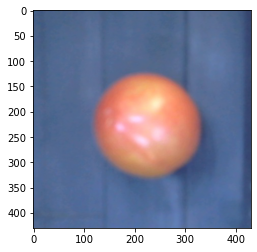

In [25]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [26]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [27]:
activations = activation_model.predict(img_tensor)

In [28]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 428, 428, 16)


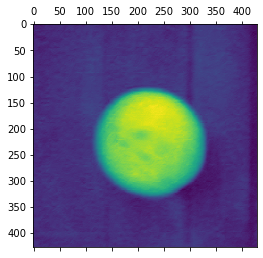

In [29]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 8], cmap='viridis')
plt.show()

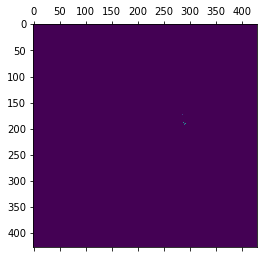

In [30]:
plt.matshow(first_layer_activation[0, :, :, 15], cmap='viridis')
plt.show()

<ipython-input-31-8d9685c149ef>:30: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


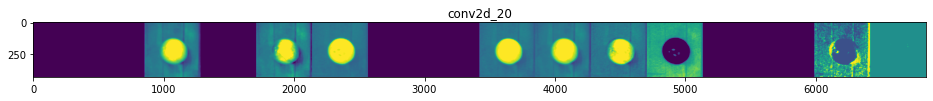

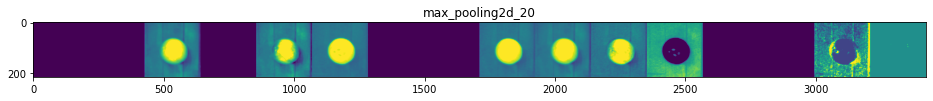

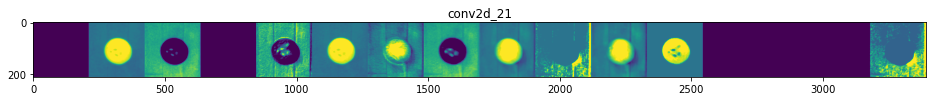

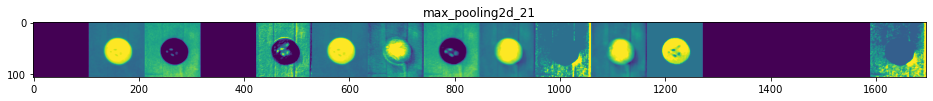

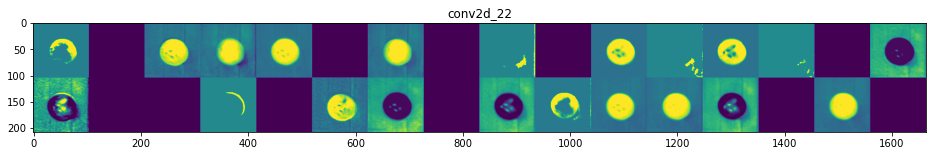

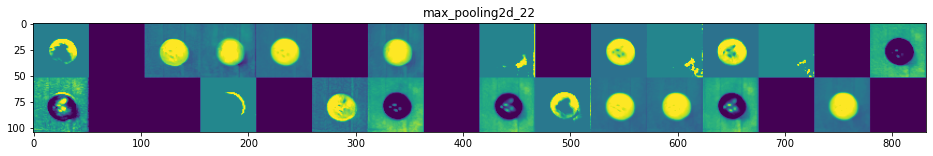

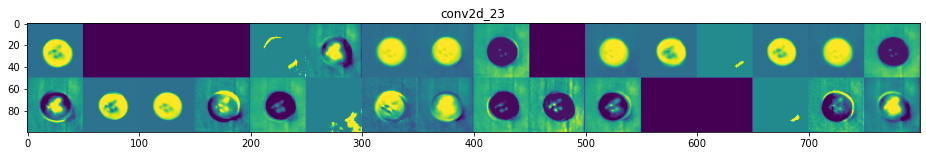

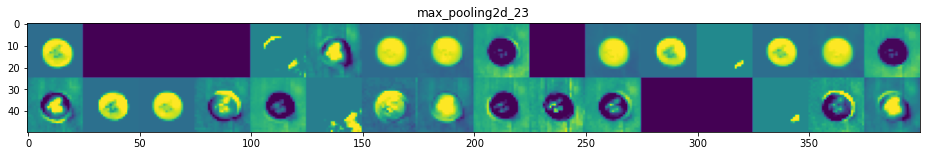

In [31]:
import keras

layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

import numpy as np
import tensorflow as tf
from tensorflow import keras

from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

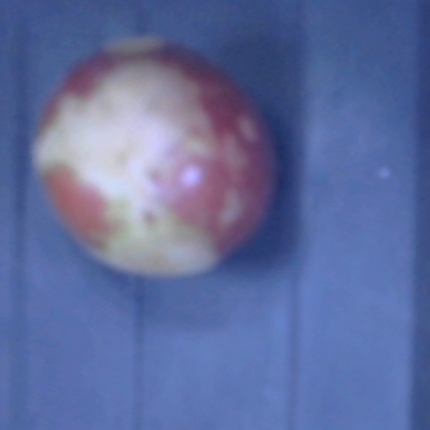

In [69]:
img_path='14.jpg'
img = image.load_img(img_path, target_size=(430, 430))
img_size = (430, 430)
a = image.img_to_array(img)
a = np.expand_dims(a, axis=0)
a /= 255.
last_conv_layer_name = "conv2d_24"
display(Image(img_path))

In [70]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

[-5.9130554 -4.257892   9.0008955]


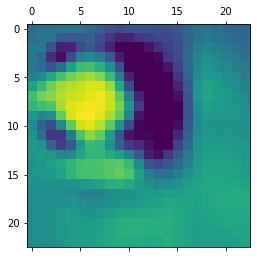

In [71]:
model.layers[-1].activation = None
preds = model.predict(a)
print((preds)[0])
heatmap = make_gradcam_heatmap(a, model, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()

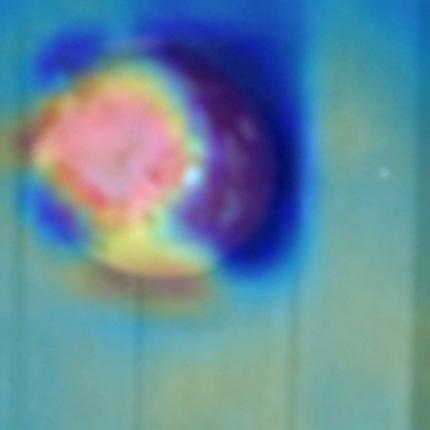

In [72]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)